In [1]:
!pip install git+https://github.com/paris-saclay-cds/ramp-workflow

  Cloning https://github.com/paris-saclay-cds/ramp-workflow to /tmp/pip-req-build-7mu7q226
  Running setup.py bdist_wheel for ramp-workflow ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-rgjllts6/wheels/35/a2/c3/7969a73ddfefc0dcad3709cb7a81f52fb90348df9bb9b8c455
Successfully built ramp-workflow


In [2]:
!pip install umap-learn

In [3]:
from problem import get_train_data
from utilities import *
import numpy as np
import scipy.stats as stats
import pandas as pd
import multiprocessing as mp

In [31]:
def parallel(fn, params):
    pool = mp.Pool(mp.cpu_count())
    res = pool.map(fn, params)
    pool.terminate()
    return res

In [5]:
X_train, y_train = get_train_data()
storm_groups = stormid_dict(X_train)
X_0d, X_zuv, X_sshv = feature_groups(X_train)
print(X_0d.describe())
print(X_zuv.describe())
print(X_sshv.describe())
y_desc = stats.describe(y_train)
print(y_desc)
print(y_train)

          instant_t     windspeed      latitude     longitude    hemisphere  \
count  15777.000000  15777.000000  15777.000000  15777.000000  15777.000000   
mean      18.234962     44.555999      9.597872     29.750683      0.716359   
std       15.012423     26.809450     19.179923    111.510315      0.450779   
min        0.000000     -1.000000    -48.000000   -179.900000      0.000000   
25%        7.000000     30.000000    -11.300000    -87.600000      0.000000   
50%       15.000000     40.000000     15.100000     66.500000      1.000000   
75%       26.000000     60.000000     21.500000    131.000000      1.000000   
max       84.000000    165.000000     65.000000    180.000000      1.000000   

       Jday_predictor  initial_max_wind  max_wind_change_12h     dist2land  \
count    1.577700e+04      15777.000000         15777.000000  15777.000000   
mean     2.417282e-01         16.868733             1.135894    835.353806   
std      3.481772e-01         13.106888            11.

In [6]:
# set constant random seed
np.random.seed(0xF)

N = 5 # number of storms to sample
storm_ids = [sid for sid in storm_groups.keys() if storm_groups[sid].shape[0] > 50]
inds = np.random.choice(range(len(storm_ids)), size=N, replace=False)
storm_dfs = [storm_groups[storm_ids[ind]] for ind in inds]

In [7]:
import matplotlib.pyplot as plt
import itertools as it
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.random_projection import SparseRandomProjection
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline

## 0-D Feature Analysis

Analysis of all 0-D features using PCA, Random Projections, t-SNE, and UMAP

In [8]:
def plot_mapping_vs_intensity_2d(X_map, ys, title="", xlabel="", ylabel="", instant_labels: pd.DataFrame = None):
    plt.scatter(X_map[:,0], X_map[:,1], c=ys, cmap='copper')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.colorbar().set_label("Storm intensity")
    if instant_labels is not None:
        for (i, xy) in enumerate(X_map):
            if i % 2 == 0:
                plt.annotate(instant_labels.values[i], xy)

In [9]:
def pca(X_df, n_components=2):
    imputer = Imputer(strategy='median')
    scaler = StandardScaler()
    pca = PCA(n_components=n_components)
    pca_pipeline = Pipeline([('med_imputer', imputer),('scaler', scaler),('pca',pca)])
    X_pc = pca_pipeline.fit_transform(X_df)    
    pca_comp_feat_ratios = np.square(pca.components_)
    feat_names = X_df.columns
    pc_feat_contrib = pd.DataFrame(pca_comp_feat_ratios, columns=feat_names)
    return X_pc, pc_feat_contrib, pca.components_, pca.explained_variance_ratio_


In [10]:
def rand_projection(X_df, n_components='auto', eps=0.1):
    imputer = Imputer(strategy='median')
    scaler = StandardScaler()
    proj = SparseRandomProjection(n_components=n_components, eps=eps)
    proj_pipeline = Pipeline([('med_imputer', imputer),('scaler', scaler),('proj', proj)])
    X_rp = proj_pipeline.fit_transform(X_df)
    return X_rp, proj.n_components_

In [11]:
def tsne(X_df, n_components=2, n_iter=5000, perplexity=30, learning_rate=100, init='pca'):
    imputer = Imputer(strategy='median')
    scaler = StandardScaler()
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, init=init, n_iter=n_iter)
    tsne_pipeline = Pipeline([('med_imputer', imputer),('scaler', scaler),('tsne', tsne)])
    X_tsne = tsne_pipeline.fit_transform(X_df)
    print("t-SNE completed after {} iterations with final KLD: {}".format(tsne.n_iter_, tsne.kl_divergence_))
    return X_tsne

In [12]:
def umap(X_df, y=None, n_components=2, n_neighbors=5, min_dist=0.1, metric='correlation'):
    imputer = Imputer(strategy='median')
    scaler = StandardScaler()
    umap = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    umap_pipeline = Pipeline([('med_imputer', imputer),('scaler', scaler),('umap', umap)])
    X_umap = umap_pipeline.fit_transform(X_df, y)
    return X_umap

In [13]:
def evaluate(X, X_maps, k=20, top_n=1, alpha='auto'):
    """
    Evaluates a collection of X_maps relative to X using the trustworthiness/continuity metric.
    Returns 'top_n' tuples of (X_map, TC score, index)
    
    X      : the original, untransformed data
    X_maps : an iterable of lower dimensional mappings to evaluate
    k      : neighborhood parameter for T&C metric
    top_n  : # of mappings to return, in descending order of score
    """
    assert top_n <= len(X_maps)
    scores = np.array([trust_cont_score(X, X_m, k=k, alpha=alpha) for X_m in X_maps])
    sorted_inds = np.argsort(scores)[::-1]
    sorted_scores = scores[sorted_inds]
    sorted_maps = [X_maps[i] for i in sorted_inds]
    return list(zip(sorted_maps, sorted_scores, sorted_inds))[:top_n]

(1797, 64)
computing metrics for PCA at d=1
computing metrics for PCA at d=2
computing metrics for PCA at d=3
computing metrics for PCA at d=4
computing metrics for PCA at d=5
computing metrics for PCA at d=6
computing metrics for PCA at d=7
computing metrics for PCA at d=8
computing metrics for PCA at d=9


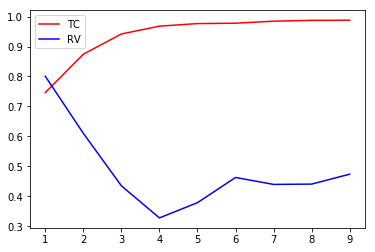

(506, 13)


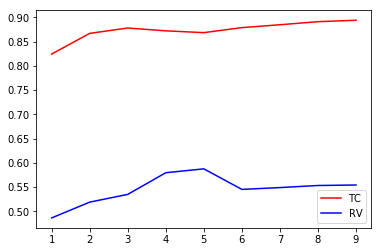

0.869145584283
0.832585729654


In [14]:
from sklearn.datasets import load_digits, load_boston

def residual_variance(X, X_m):
    from sklearn.neighbors import kneighbors_graph
    from sklearn.metrics import pairwise_distances
    from sklearn.utils.graph_shortest_path import graph_shortest_path
    from scipy.stats import pearsonr
    
    #kng_h = kneighbors_graph(X, n_neighbors=10, mode='distance').toarray()
    #D_h = graph_shortest_path(kng_h, method='D', directed=False)
    D_h = pairwise_distances(X, X, metric='euclidean')
    #D_l = kneighbors_graph(X_m, n_neighbors=50, mode='distance').toarray()
    D_l = pairwise_distances(X_m, X_m, metric='euclidean')
    r,_ = pearsonr(D_h.flatten(), D_l.flatten())
    return 1 - r**2.0

digits = load_digits()
print(digits.data.shape)
N = digits.data.shape[0]
X_digits = digits.data
y_digits = digits.target
ds = list(range(1, 10))
ts = []
rs = []
for d in ds:
    print('computing metrics for PCA at d={}'.format(d))
    X_pc,_,_,_ = pca(pd.DataFrame(X_digits), d)
    ts.append(trust_cont_score(X_digits, X_pc, k=12))
    rs.append(residual_variance(X_digits, X_pc))

plt.plot(ds, ts, c='red')
plt.plot(ds, rs, c='blue')
plt.legend(['TC', 'RV'])
plt.show()

X_rp_all = [rand_projection(X_digits, 2)[0] for i in range(10)]

housing = load_boston()
print(housing.data.shape)
X_housing = housing.data
y_housing = housing.target
ds = list(range(1, 10))
ts = []
rs = []
for d in ds:
    X_pc,_,_,_ = pca(pd.DataFrame(X_housing), d)
    ts.append(trust_cont_score(X_housing, X_pc, k=12))
    rs.append(residual_variance(X_housing, X_pc))

plt.plot(ds, ts, c='red')
plt.plot(ds, rs, c='blue')
plt.legend(['TC', 'RV'])
plt.show()

X_pc,_,_,_ = pca(pd.DataFrame(X_housing), 2)
print(trust_cont_score(X_housing, X_pc, k=10))
X_rp_all = [rand_projection(X_housing, 2)[0] for i in range(10)]
X_rp, tc, _ = evaluate(X_housing, X_rp_all, k=10)[0]
print(tc)

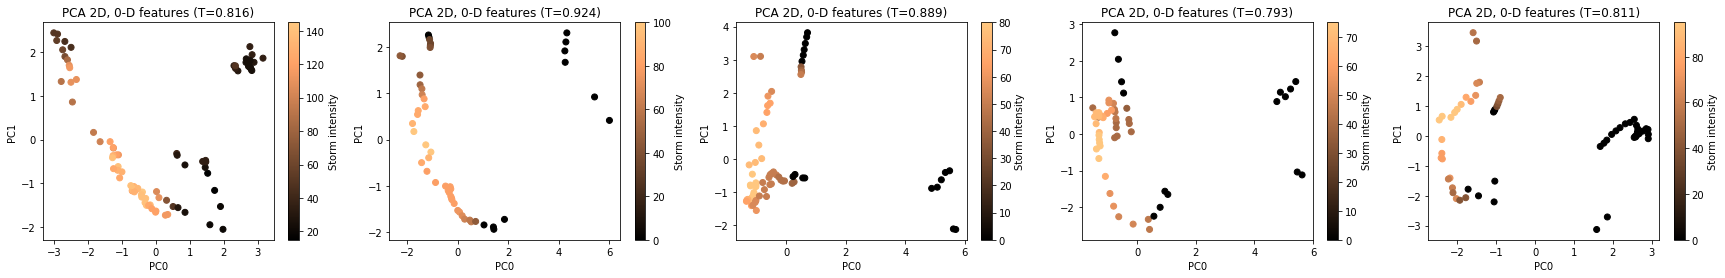

In [15]:
plt.figure(figsize=(30,4))
for i, X_df in enumerate(storm_dfs):
    sid = X_df.stormid.at(0)
    X_0d, X_zuv, X_sshv = feature_groups(X_df)
    basin_col_names = [c for c in X_0d.columns if c.startswith('basin')]
    X_0d_trimmed = X_0d.drop(['instant_t', 'hemisphere', 'initial_max_wind'] + basin_col_names, axis=1)
    X_pc, pc_feat_contrib, pcs, evr = pca(X_0d_trimmed, 2)
    ys = y_train[X_df.index]
    #print(pc_feat_contrib)
    tc = trust_cont_score(X_0d_trimmed, X_pc, k=10)
    plt.subplot(1, len(storm_dfs), i + 1)
    plot_mapping_vs_intensity_2d(X_pc, ys, "PCA 2D, 0-D features (T={:.3f})".format(tc), "PC0", "PC1")

plt.show()

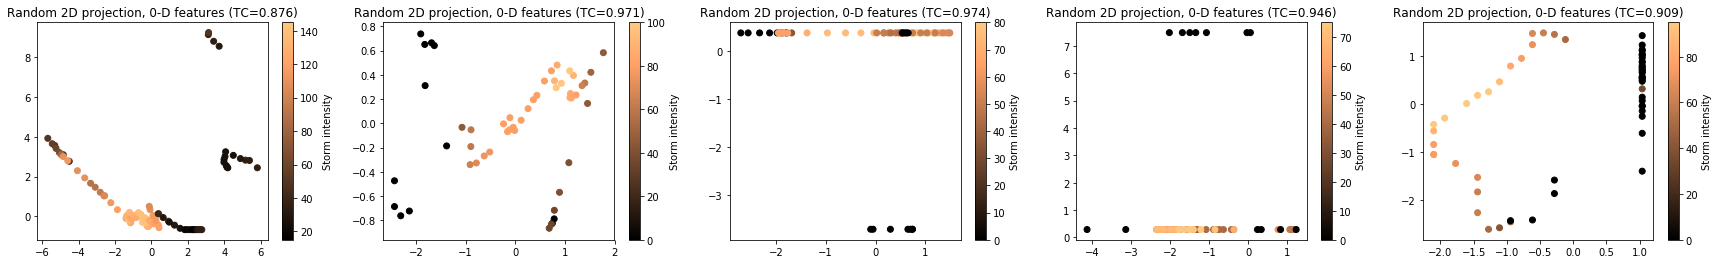

In [16]:
N = 50 # number of runs
plt.figure(figsize=(30,4))
for i, X_df in enumerate(storm_dfs):
    X_0d, X_zuv, X_sshv = feature_groups(X_df)
    basin_col_names = [c for c in X_0d.columns if c.startswith('basin')]
    X_0d_trimmed = X_0d.drop(['instant_t', 'hemisphere', 'initial_max_wind'] + basin_col_names, axis=1)
    X_rps = [rand_projection(X_0d_trimmed, n_components=2)[0] for k in range(N)]
    ys = y_train[X_df.index]
    X_rps_scored = evaluate(X_0d_trimmed, X_rps, k=10, top_n=1)
    X_rp_best, tc_best, _ = X_rps_scored[0]
    plt.subplot(1, len(storm_dfs), i+1)
    plot_mapping_vs_intensity_2d(X_rp_best, ys, title='Random 2D projection, 0-D features (TC={:.3f})'.format(tc_best))

plt.show()

t-SNE completed after 3649 iterations with final KLD: 0.13448210060596466
t-SNE completed after 2299 iterations with final KLD: 0.1342846304178238
t-SNE completed after 1399 iterations with final KLD: 0.09695766866207123
t-SNE completed after 1249 iterations with final KLD: 0.07575961202383041
t-SNE completed after 899 iterations with final KLD: 0.043572843074798584
t-SNE completed after 899 iterations with final KLD: 0.03857215493917465
t-SNE completed after 799 iterations with final KLD: 0.032333653420209885
t-SNE completed after 1249 iterations with final KLD: 0.025630829855799675
t-SNE completed after 749 iterations with final KLD: 0.023347409442067146
t-SNE completed after 4199 iterations with final KLD: 0.09371889382600784
t-SNE completed after 3299 iterations with final KLD: 0.07200004905462265
t-SNE completed after 1799 iterations with final KLD: 0.051397502422332764
t-SNE completed after 1949 iterations with final KLD: 0.03658158704638481
t-SNE completed after 1349 iterations 

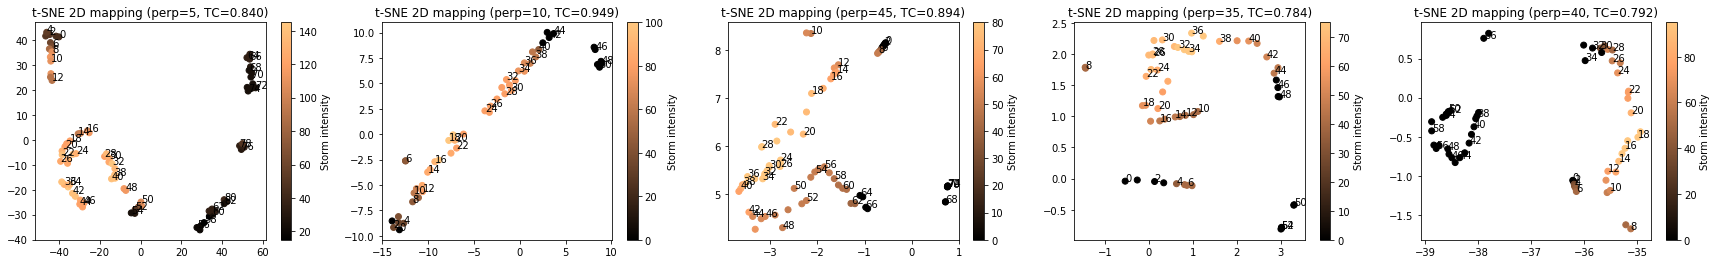

In [17]:
plt.figure(figsize=(30,4))
for i, X_df in enumerate(storm_dfs):
    X_0d, X_zuv, X_sshv = feature_groups(X_df)
    basin_col_names = [c for c in X_0d.columns if c.startswith('basin')]
    X_0d_trimmed = X_0d.drop(['instant_t', 'hemisphere', 'initial_max_wind'] + basin_col_names, axis=1)
    perplexities = np.arange(5, 50, 5)
    X_tsne_maps = [tsne(X_0d_trimmed, 2, perplexity=p) for p in perplexities]
    X_tsne, tc, ind = evaluate(X_0d_trimmed, X_tsne_maps, k=10)[0]
    p = perplexities[ind]
    ys = y_train[X_df.index]
    plt.subplot(1, len(storm_dfs), i+1)
    plot_mapping_vs_intensity_2d(X_tsne, ys, title="t-SNE 2D mapping (perp={}, TC={:.3f})".format(p, tc), instant_labels=X_0d['instant_t'])
    
plt.show()

Running UMAP on all parameter sets for storm 0
Running UMAP on all parameter sets for storm 1
Running UMAP on all parameter sets for storm 2
Running UMAP on all parameter sets for storm 3
Running UMAP on all parameter sets for storm 4


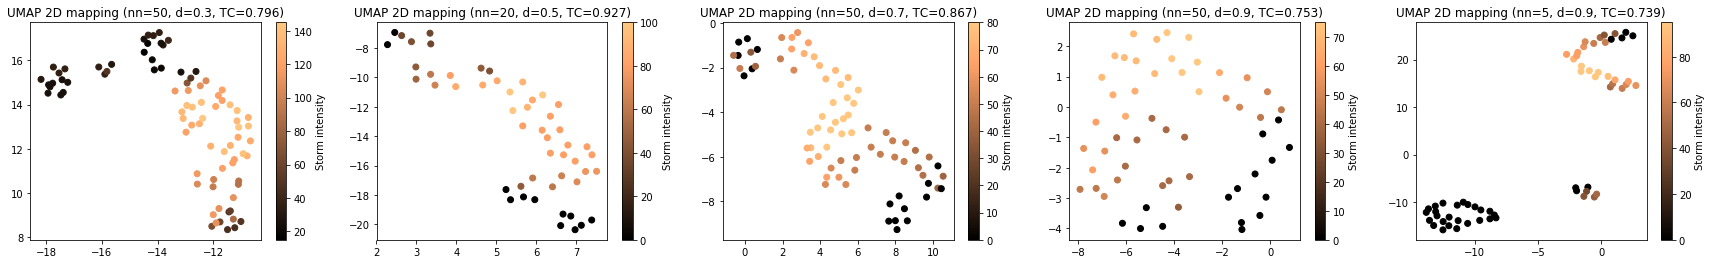

In [18]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(30, 4))
for i, X_df in enumerate(storm_dfs):
    X_0d, X_zuv, X_sshv = feature_groups(X_df)
    basin_col_names = [c for c in X_0d.columns if c.startswith('basin')]
    X_0d_trimmed = X_0d.drop(['instant_t', 'hemisphere', 'initial_max_wind'] + basin_col_names, axis=1)
    n_neighbors = [5, 10, 20, 50]
    min_dist = np.arange(0.1, 1.0, 0.2)
    ys = y_train[X_df.index]
    params = list(it.product(n_neighbors, min_dist))
    print('Running UMAP on all parameter sets for storm {}'.format(i))
    X_umap_all = [umap(X_0d_trimmed, n_components=2, n_neighbors=nn, min_dist=d) for (nn, d) in params]
    X_umap, tc, ind = evaluate(X_0d, X_umap_all, k=20, top_n=1)[0]
    nn, d = params[ind]
    plt.subplot(1, len(storm_dfs), i+1)
    plot_mapping_vs_intensity_2d(X_umap, ys, title="UMAP 2D mapping (nn={}, d={:.1f}, TC={:.3f})".format(nn, d, tc))

plt.show()

warnings.filterwarnings('default')

In [19]:
N_storms = 100
storms = pd.unique(X_train['stormid'])
selected_storms = np.random.choice(storms, size=N_storms, replace=False)
X = X_train[X_train['stormid'].isin(selected_storms)]
X_0d, X_zuv, X_sshv = feature_groups(X)
bas_cols = [c for c in X_0d.columns if c.startswith('basin')]
nat_cols = [c for c in X_0d.columns if c.startswith('nature')]
X_0d = X_0d.drop(['instant_t'], axis=1)
X_0d_no_basin = X_0d.drop(bas_cols, axis=1)
X_0d_no_nature = X_0d.drop(nat_cols, axis=1)

# First, 0D features
y = y_train[X.index]
nat = X.nature
nat_labels = ['Tropical', 'Subtropical', 'Extratropical', 'Disturbance', 'Mixed', 'Not reported', 'Missing']
bas = X.basin
bas_labels = ['NA','SA','WP','EP','SP','NI','SI','AS','BB','EA','WA','CP','CS','GM','MM']

def plot_mapping_2d(X_map, title, X_ccol, clabels, cmap):
    cvals = pd.unique(X_ccol)
    cvals.sort()
    colors = plt.get_cmap(cmap)(range(len(cvals)))
    plots = []
    for i, c in enumerate(cvals):
        ind = np.where(X_ccol == c)
        plots.append(plt.scatter(X_map[ind,0], X_map[ind,1], c=colors[i], alpha=0.5))
    plt.legend(plots, [clabels[c] for c in cvals])
    plt.title(title)

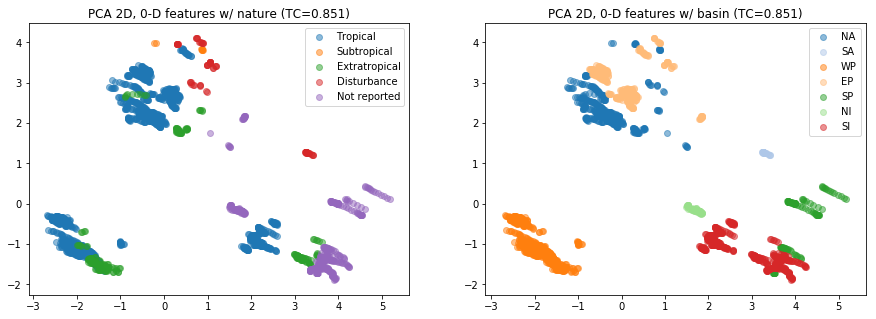

In [20]:
#### PCA
X_pc,_,_,_ = pca(X_0d, 2)
tc = trust_cont_score(X_0d, X_pc, k=10)
#X_pc_nat, pc_feat_contrib, _, _ = pca(X_0d_no_nature, 2)
#X_pc_bas, pc_feat_contrib, _, _ = pca(X_0d_no_basin, 2)
#tc_nat = trust_cont_score(X_0d_no_nature, X_pc_nat, k=10)
#tc_bas = trust_cont_score(X_0d_no_basin, X_pc_bas, k=10)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_mapping_2d(X_pc, "PCA 2D, 0-D features w/ nature (TC={:.3f})".format(tc), nat, nat_labels, 'tab10')
plt.subplot(1,2,2)
plot_mapping_2d(X_pc, "PCA 2D, 0-D features w/ basin (TC={:.3f})".format(tc), bas, bas_labels, 'tab20')
plt.show()

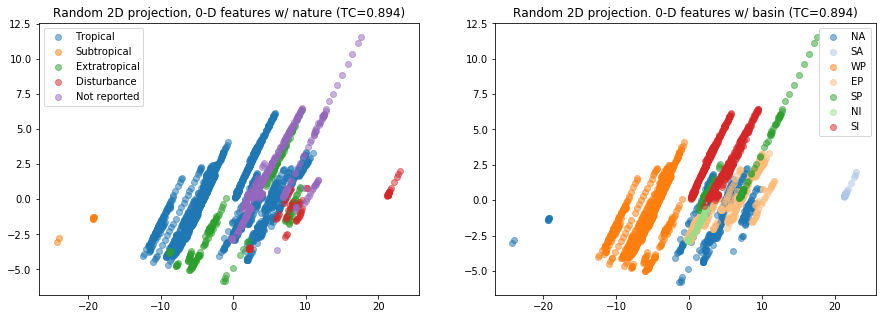

In [29]:
# random projection
N = 50
plt.figure(figsize=(15,5))
def run_rp(i):
    return rand_projection(X_0d, n_components=2)[0]
X_rp_all = parallel(run_rp, range(N))
X_rp, tc, _ = evaluate(X_0d, X_rp_all, k=10)[0]
#X_rp_nat_all = [rand_projection(X_0d_no_nature, n_components=2)[0] for i in range(N)]
#X_rp_bas_all = [rand_projection(X_0d_no_basin, n_components=2)[0] for i in range(N)]
#X_rp_nat, tc_nat, _ = evaluate(X_0d_no_nature, X_rp_nat_all, k=10)[0]
#X_rp_bas, tc_bas, _ = evaluate(X_0d_no_basin, X_rp_bas_all, k=10)[0]
plt.subplot(1,2,1)
plot_mapping_2d(X_rp, "Random 2D projection, 0-D features w/ nature (TC={:.3f})".format(tc), nat, nat_labels, 'tab10')
plt.subplot(1,2,2)
plot_mapping_2d(X_rp, "Random 2D projection. 0-D features w/ basin (TC={:.3f})".format(tc), bas, bas_labels, 'tab20')
plt.show()

t-SNE completed after 999 iterations with final KLD: 0.34713155031204224
t-SNE completed after 999 iterations with final KLD: 0.2817273437976837
t-SNE completed after 999 iterations with final KLD: 0.24068254232406616
t-SNE completed after 999 iterations with final KLD: 0.21105463802814484
200


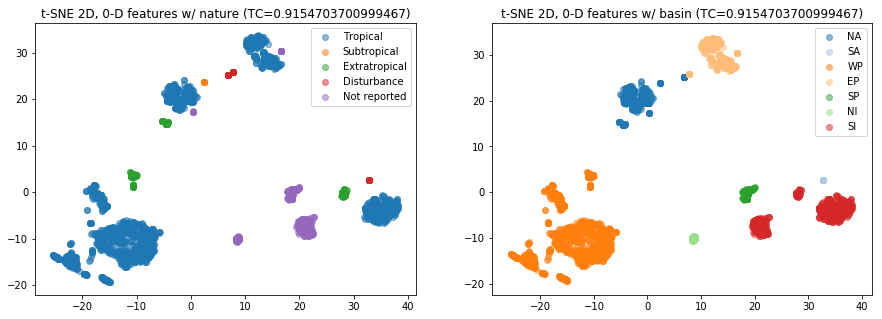

In [30]:
# t-SNE
plt.figure(figsize=(15,5))
perplexities = np.arange(50, 201, 50)
def run_tsne(p):
    return tsne(X_0d, 2, perplexity=p, learning_rate=300, n_iter=1000)
X_tsne_maps = parallel(run_tsne, perplexities)
X_tsne, tc, i = evaluate(X_0d, X_tsne_maps, k=10)[0]
print(perplexities[i])
plt.subplot(1,2,1)
plot_mapping_2d(X_tsne, "t-SNE 2D, 0-D features w/ nature (TC={})".format(tc), nat, nat_labels, 'tab10')
plt.subplot(1,2,2)
plot_mapping_2d(X_tsne, "t-SNE 2D, 0-D features w/ basin (TC={})".format(tc), bas, bas_labels, 'tab20')

In [35]:
# UMAP
n_neighbors = [10, 20]
min_dist = [0.1, 0.3, 0.6]
params = list(it.product(n_neighbors, min_dist))
def run_umap(p):
    return umap(X_0d, n_components=2, n_neighbors=nn, min_dist=d)
X_umap_all = parallel(run_umap, params)
X_umap, tc, ind = evaluate(X_0d, X_umap_all, k=10)[0]
#X_umap_nat_all = [umap(X_0d_no_nature, n_components=2, n_neighbors=nn, min_dist=d) for (nn, d) in params]
#X_umap_bas_all = [umap(X_0d_no_basin, n_components=2, n_neighbors=nn, min_dist=d) for (nn, d) in params]
#X_umap_nat, tc_nat, _ = evaluate(X_0d_no_nature, X_umap_nat_all, k=10)[0]
#X_umap_bas, tc_bas, _ = evaluate(X_0d_no_basin, X_umap_bas_all, k=10)[0]
nn, d = params[ind]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_mapping_2d(X_umap, "UMAP 2D mapping of 0D features w/ nature (nn={}, d={:0.1f}, TC={:.3f})".format(nn, d, tc), nat, nat_labels, 'tab10')
plt.subplot(1,2,2)
plot_mapping_2d(X_umap, "UMAP 2D mapping of 0D features w/ basin (nn={}, d={:0.1f}, TC={:.3f})".format(nn, d, tc), bas, bas_labels, 'tab20')
plt.show()

TypeError: run_umap() missing 1 required positional argument: 'd'

## 2-D Reanalysis data feature analysis

Analysis of 2-D reanalysis data features

In [ ]:
plt.figure(figsize=(15,30))
for i, X_df in enumerate(storm_dfs):
    _, X_zuv, X_sshv = feature_groups(X_df)
    X_pc_zuv, pc_feat_contrib_zuv, _, _ = pca(X_zuv, 2)
    X_pc_sshv, pc_feat_contrib_sshv, _, _ = pca(X_sshv, 2)
    ys = y_train[X_df.index]
    plt.subplot(len(storm_dfs), 2, 2*i+1)
    plot_mapping_vs_intensity_2d(X_pc_zuv, ys, "zuv-wind map PCA 2D", "PC0", "PC1")
    plt.subplot(len(storm_dfs), 2, 2*i+2)
    plot_mapping_vs_intensity_2d(X_pc_sshv, ys, "sshv map PCA 2D", "PC0", "PC1")
    
plt.show()

In [ ]:
GRID_SIZE = 11
plt.figure(figsize=(35,20))
params = ['z', 'u', 'v', 'sst', 'slp', 'hum', 'vo700']
for i, X_df in enumerate(storm_dfs[:3]):
    _, X_zuv, X_sshv = feature_groups(X_df)
    X_2dr = pd.concat((X_zuv, X_sshv), axis=1)
    for j, p in enumerate(params):
        X_p = X_2dr.get([c for c in X_2dr.columns if c.startswith(p)])
        _, pc_feat_contrib, _, _ = pca(X_p, 2)
        img = np.zeros((GRID_SIZE, GRID_SIZE))
        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                img[x,y] = pc_feat_contrib["{}_{}_{}".format(p, x, y)][0] # % contrib to first principal axis
        plt.subplot(len(storm_dfs), len(params), i*len(params)+j+1)
        plt.imshow(img, extent=[-5,5,-5,5], interpolation='nearest', origin='lower', cmap='seismic')
        plt.xlabel(p)
        
plt.suptitle("11x11 feature maps, % contribution to first principal axis\n(PCA computed independently per parameter)", fontsize=28)
plt.show()

In [ ]:
plt.figure(figsize=(15,15))
for i, X_df in enumerate(storm_dfs):
    _, X_zuv, X_sshv = feature_groups(X_df)
    # reduce dimensionality to ~50 via PCA before running t-SNE
    X_pc_zuv, _, _, _ = pca(X_zuv, 50)
    X_pc_sshv, _, _, _ = pca(X_sshv, 50)
    ys = y_train[X_df.index]
    X_tsne_zuv = tsne(X_zuv, 2)
    X_tsne_sshv = tsne(X_sshv, 2)
    plt.subplot(len(storm_dfs), 2, 2*i+1)
    plot_mapping_vs_intensity_2d(X_tsne_zuv, ys, "t-SNE 2D mapping zuv-wind")
    plt.subplot(len(storm_dfs), 2, 2*i+2)
    plot_mapping_vs_intensity_2d(X_tsne_sshv, ys, "t-SNE 2D mapping sshv")
    
plt.show()

In [ ]:
# PCA
plt.figure(figsize=(15,10))
X_zuv_pc, pc_feat_contrib, _, _ = pca(X_zuv, 2)
tc = trust_cont_score(X_zuv, X_zuv_pc, k=10)
plt.subplot(2,2,1)
plot_mapping_2d(X_zuv_pc, "PCA 2D, zuv map features w/ nature (TC={:.3f})".format(tc), nat, nat_labels, 'tab10')
plt.subplot(2,2,2)
plot_mapping_2d(X_zuv_pc, "PCA 2D, zuv map features w/ basin (TC={:.3f})".format(tc), bas, bas_labels, 'tab20')

X_sshv_pc, pc_feat_contrib, _, _ = pca(X_sshv, 2)
plt.subplot(2,2,3)
plot_mapping_2d(X_sshv_pc, "PCA 2D mapping of sshv map features vs nature", nat, nat_labels, 'tab10')
plt.subplot(2,2,4)
plot_mapping_2d(X_sshv_pc, "PCA 2D mapping of sshv map features vs basin", bas, bas_labels, 'tab20')
plt.show()

In [ ]:
# random projection
plt.figure(figsize=(15,10))
X_zuv_rp, _ = rand_projection(X_zuv, 2)
plt.subplot(2,2,1)
plot_mapping_2d(X_zuv_rp, "Random 2D mapping of zuv map features vs nature", nat, nat_labels, 'tab10')
plt.subplot(2,2,2)
plot_mapping_2d(X_zuv_rp, "Random 2D mapping of zuv map features vs basin", bas, bas_labels, 'tab20')

X_sshv_rp, _ = rand_projection(X_sshv, 2)
plt.subplot(2,2,3)
plot_mapping_2d(X_sshv_rp, "Random 2D mapping of sshv map features vs nature", nat, nat_labels, 'tab10')
plt.subplot(2,2,4)
plot_mapping_2d(X_sshv_rp, "Random 2D mapping of sshv map features vs basin", bas, bas_labels, 'tab20')

In [ ]:
# t-SNE
plt.figure(figsize=(15,10))

X_zuv_tsne = tsne(X_t0_zuv, 2, learning_rate=150, perplexity=128)
plt.subplot(2,2,1)
plot_mapping_2d(X_zuv_tsne, "t-SNE 2D mapping of zuv map features vs nature", nat, nat_labels, 'tab10')
plt.subplot(2,2,2)
plot_mapping_2d(X_zuv_tsne, "t-SNE 2D mapping of zuv map features vs basin", bas, bas_labels, 'tab20')

X_sshv_tsne = tsne(X_t0_sshv, 2, learning_rate=150, perplexity=128)
plt.subplot(2,2,3)
plot_mapping_2d(X_sshv_tsne, "t-SNE 2D mapping of sshv map features vs nature", nat, nat_labels, 'tab10')
plt.subplot(2,2,4)
plot_mapping_2d(X_sshv_tsne, "t-SNE 2D mapping of sshv map features vs basin", bas, bas_labels, 'tab20')
plt.show()

In [ ]:
# UMAP
plt.figure(figsize=(20,35))
X_zuv_umap = umap(X_t0_zuv, n_components=2, n_neighbors=100, min_dist=0.2)
plt.subplot(6, 2, 1)
plot_mapping_2d(X_zuv_umap, "UMAP 2D mapping of zuv map features vs nature", nat, nat_labels, 'tab10')
plt.subplot(6, 2, 2)
plot_mapping_2d(X_zuv_umap, "UMAP 2D mapping of zuv map features vs basin", bas, bas_labels, 'tab20')

X_zuv_umap_y = umap(X_t0_zuv, y=y_t0, n_components=2, n_neighbors=100, min_dist=0.2)
plt.subplot(6, 2, 3)
plot_mapping_2d(X_zuv_umap_y, "UMAP 2D mapping of zuv map features vs nature (supervised by storm intensity)", nat, nat_labels, 'tab10')
plt.subplot(6, 2, 4)
plot_mapping_2d(X_zuv_umap_y, "UMAP 2D mapping of zuv map features vs basin (supervised by storm intensity)", bas, bas_labels, 'tab20')

X_zuv_umap_nat = umap(X_t0_zuv, y=nat, n_components=2, n_neighbors=20, min_dist=0.99)
plt.subplot(6, 2, 5)
plot_mapping_2d(X_zuv_umap_nat, "UMAP 2D mapping of zuv map features vs nature (supervised by nature)", nat, nat_labels, 'tab10')
X_zuv_umap_bas = umap(X_t0_zuv, y=bas, n_components=2, n_neighbors=20, min_dist=0.99)
plt.subplot(6, 2, 6)
plot_mapping_2d(X_zuv_umap_bas, "UMAP 2D mapping of zuv map features vs basin (supervised by basin)", bas, bas_labels, 'tab20')

X_sshv_umap = umap(X_t0_sshv, n_components=2, n_neighbors=100, min_dist=0.2)
plt.subplot(6, 2, 7)
plot_mapping_2d(X_sshv_umap, "UMAP 2D mapping of sshv map features vs nature", nat, nat_labels, 'tab10')
plt.subplot(6, 2, 8)
plot_mapping_2d(X_sshv_umap, "UMAP 2D mapping of sshv map features vs basin", bas, bas_labels, 'tab20')

X_sshv_umap_y = umap(X_t0_sshv, y=y_t0, n_components=2, n_neighbors=100, min_dist=0.2)
plt.subplot(6, 2, 9)
plot_mapping_2d(X_sshv_umap_y, "UMAP 2D mapping of sshv map features vs nature (supervised by storm intensity)", nat, nat_labels, 'tab10')
plt.subplot(6, 2, 10)
plot_mapping_2d(X_sshv_umap_y, "UMAP 2D mapping of sshv map features vs basin (superivsed by storm intensity)", bas, bas_labels, 'tab20')

X_sshv_umap_nat = umap(X_t0_sshv, y=nat, n_components=2, n_neighbors=20, min_dist=0.99)
plt.subplot(6, 2, 11)
plot_mapping_2d(X_sshv_umap_nat, "UMAP 2D mapping of sshv map features vs nature (supervised by nature)", nat, nat_labels, 'tab10')
X_sshv_umap_bas = umap(X_t0_sshv, y=bas, n_components=2, n_neighbors=20, min_dist=0.99)
plt.subplot(6, 2, 12)
plot_mapping_2d(X_sshv_umap_bas, "UMAP 2D mapping of sshv map features vs basin (supervised by basin)", bas, bas_labels, 'tab20')

plt.show()

### Combined analysis

0-D features w/ reanalysis data

In [33]:
X_0d_zuv = pd.concat([X_0d, X_zuv], axis=1)
X_0d_sshv = pd.concat([X_0d, X_sshv], axis=1)
X_all = pd.concat([X_0d, X_zuv, X_sshv], axis=1)

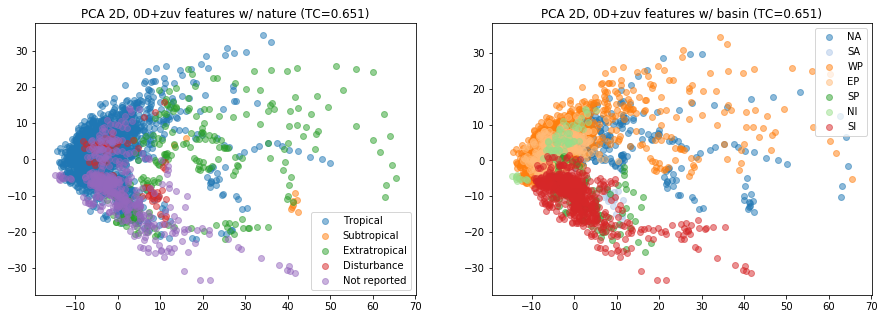

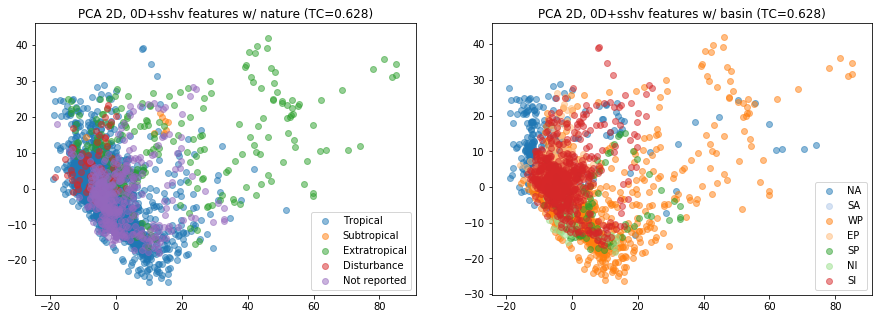

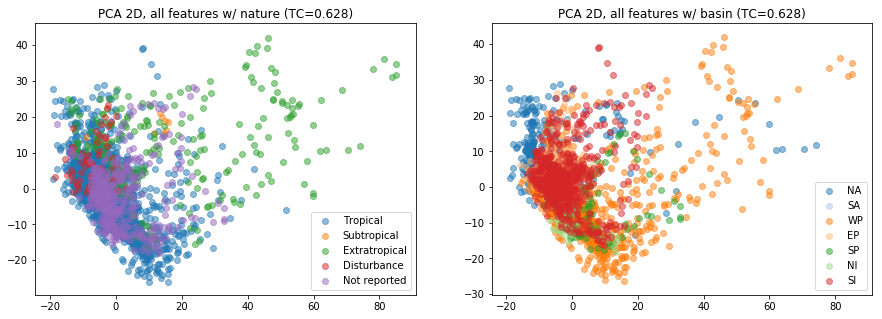

In [34]:
#### PCA
X_pc,_,_,_ = pca(X_0d_zuv, 2)
tc = trust_cont_score(X_0d, X_pc, k=10)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_mapping_2d(X_pc, "PCA 2D, 0D+zuv features w/ nature (TC={:.3f})".format(tc), nat, nat_labels, 'tab10')
plt.subplot(1,2,2)
plot_mapping_2d(X_pc, "PCA 2D, 0D+zuv features w/ basin (TC={:.3f})".format(tc), bas, bas_labels, 'tab20')
plt.show()

X_pc,_,_,_ = pca(X_0d_sshv, 2)
tc = trust_cont_score(X_0d, X_pc, k=10)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_mapping_2d(X_pc, "PCA 2D, 0D+sshv features w/ nature (TC={:.3f})".format(tc), nat, nat_labels, 'tab10')
plt.subplot(1,2,2)
plot_mapping_2d(X_pc, "PCA 2D, 0D+sshv features w/ basin (TC={:.3f})".format(tc), bas, bas_labels, 'tab20')
plt.show()

X_pc,_,_,_ = pca(X_0d_sshv, 2)
tc = trust_cont_score(X_0d, X_pc, k=10)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_mapping_2d(X_pc, "PCA 2D, all features w/ nature (TC={:.3f})".format(tc), nat, nat_labels, 'tab10')
plt.subplot(1,2,2)
plot_mapping_2d(X_pc, "PCA 2D, all features w/ basin (TC={:.3f})".format(tc), bas, bas_labels, 'tab20')
plt.show()